# Aligned UMAP

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load common_.py
from common import *

In [3]:
import umap
from ehv import core, load as e_load
from joblib import dump, load
from pathlib import Path
from matplotlib import cm
import matplotlib
import statsmodels.api as sm

In [4]:
df = e_load.load_raw_ideas_dir(
    Path("/data/weizmann/EhV/high_time_res"), 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/representations/ideas_features/"), 
    "ALL", 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/cell_populations/manual_gating/"),
    pandas.read_csv("data/selected_samples.csv"), "Low/*.cif")
df = e_load.remove_unwanted_features(df)
df = e_load.tag_columns(df)
df = e_load.clean_column_names(df)

In [5]:
df = df[df["meta_label_coi"]]
df.shape

(293029, 113)

In [6]:
with open("data/selected_features.txt") as fh:
    features = [i.lower() for i in fh.read().split(",")]
features.extend(df.filter(regex="meta").columns.values.tolist())

df = df[features]

In [7]:
import re
reg = r"^meta_label_(.+)$"
label_vec = numpy.full((df.shape[0]), fill_value="unknown", dtype=object)
for col in df.filter(regex="(?i)meta_label_.*psba.*"):
    label_vec[df[col].values] = re.match(reg, col).groups(1)
    
df["meta_label"] = label_vec

In [8]:
def zscore_feat_cols(col):
    if "feat" in col.name:
        return (col - col.mean(axis=0))/col.std(axis=0)
    else:
        return col

df = df.apply(zscore_feat_cols, axis=0)

In [9]:
df = df.groupby(["meta_timepoint", "meta_replicate"]).apply(lambda df: df.apply(zscore_feat_cols, axis=0))

In [10]:
df.shape

(293029, 102)

# Define relationships between timepoints

In [40]:
from scipy import spatial
from joblib import Parallel, delayed

def get_min_index(s, target):
    distances = target.apply(lambda row: spatial.distance.cosine(s, row), axis=1)    
    return distances.argmin()

def get_min_distance_index(source, target, n=10, dist=spatial.distance.cosine):
    target = target.copy().reset_index(drop=True)
    indices = numpy.random.choice(len(source), replace=False, size=n)
    min_indices = Parallel(n_jobs=24)(delayed(get_min_index)(source.iloc[index], target) for index in indices)        
    return {k:v for k,v in zip(indices, min_indices)}

In [41]:
%%time
get_min_distance_index(df[df["meta_timepoint"] == 0].filter(regex="feat"), df[df["meta_timepoint"] == 1].filter(regex="feat"), n=100)

CPU times: user 641 ms, sys: 1.15 s, total: 1.79 s
Wall time: 31.7 s


{3043: 3050,
 9009: 8234,
 8442: 9079,
 1794: 5983,
 8825: 4573,
 6092: 8540,
 3527: 11622,
 4060: 3287,
 5888: 2895,
 4381: 5307,
 6775: 5772,
 5382: 7401,
 3720: 5259,
 8898: 4342,
 8191: 6025,
 8489: 5971,
 6380: 1304,
 1430: 428,
 2228: 3112,
 7036: 11762,
 8761: 9378,
 3693: 3112,
 6773: 4458,
 5241: 11870,
 1339: 10752,
 7075: 7646,
 5793: 8495,
 3378: 11836,
 8992: 4774,
 6841: 597,
 7942: 2765,
 2887: 8701,
 6253: 12048,
 3838: 2414,
 2718: 1936,
 6289: 3593,
 8271: 2420,
 80: 8007,
 4423: 226,
 3078: 3181,
 730: 2374,
 5333: 10060,
 7090: 4772,
 2436: 691,
 3024: 737,
 5747: 5546,
 3666: 6064,
 5106: 6164,
 8041: 7128,
 8964: 893,
 2302: 257,
 8049: 7049,
 8083: 7576,
 3460: 5390,
 3686: 2516,
 8468: 5773,
 6244: 12142,
 3842: 12166,
 7391: 5914,
 2245: 4791,
 7712: 8818,
 6419: 1250,
 2609: 8749,
 1479: 10153,
 1076: 7894,
 1570: 4505,
 653: 7434,
 93: 821,
 8831: 5779,
 1071: 270,
 1918: 11105,
 1297: 6590,
 1195: 8987,
 5354: 2516,
 518: 1567,
 2303: 10150,
 5454: 7776,
 30

In [43]:
%%time
from tqdm.notebook import tqdm
tps = sorted(df["meta_timepoint"].unique())
relations = []
for i,j in tqdm(zip(tps[0:-1], tps[1:]), total=len(tps)-1):
    relations.append(get_min_distance_index(df[df["meta_timepoint"] == i].filter(regex="feat"), df[df["meta_timepoint"] == j].filter(regex="feat"), n=500))

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 45.7 s, sys: 5.64 s, total: 51.3 s
Wall time: 1h 1min 20s


In [44]:
dump(relations, "data/relations.dat")

['data/relations.dat']

In [45]:
%%time
slices = [v.filter(regex="feat") for _,v in df.groupby("meta_timepoint", sort=True)]
aligned_mapper = umap.AlignedUMAP(metric="cosine").fit(slices, relations=relations)

CPU times: user 36min 28s, sys: 4min 45s, total: 41min 13s
Wall time: 18min 27s


In [54]:
embeddings = []
for embedding in aligned_mapper.embeddings_:
    embeddings.append(embedding)

In [55]:
dump(embeddings, "data/umap/aligned_HTR_COI_after_selection_cosine.dat")

['data/umap/aligned_HTR_COI_after_selection_cosine.dat']

In [46]:
def axis_bounds(embedding):
    left, right = embedding.T[0].min(), embedding.T[0].max()
    bottom, top = embedding.T[1].min(), embedding.T[1].max()
    adj_h, adj_v = (right - left) * 0.1, (top - bottom) * 0.1
    return [left - adj_h, right + adj_h, bottom - adj_v, top + adj_v]

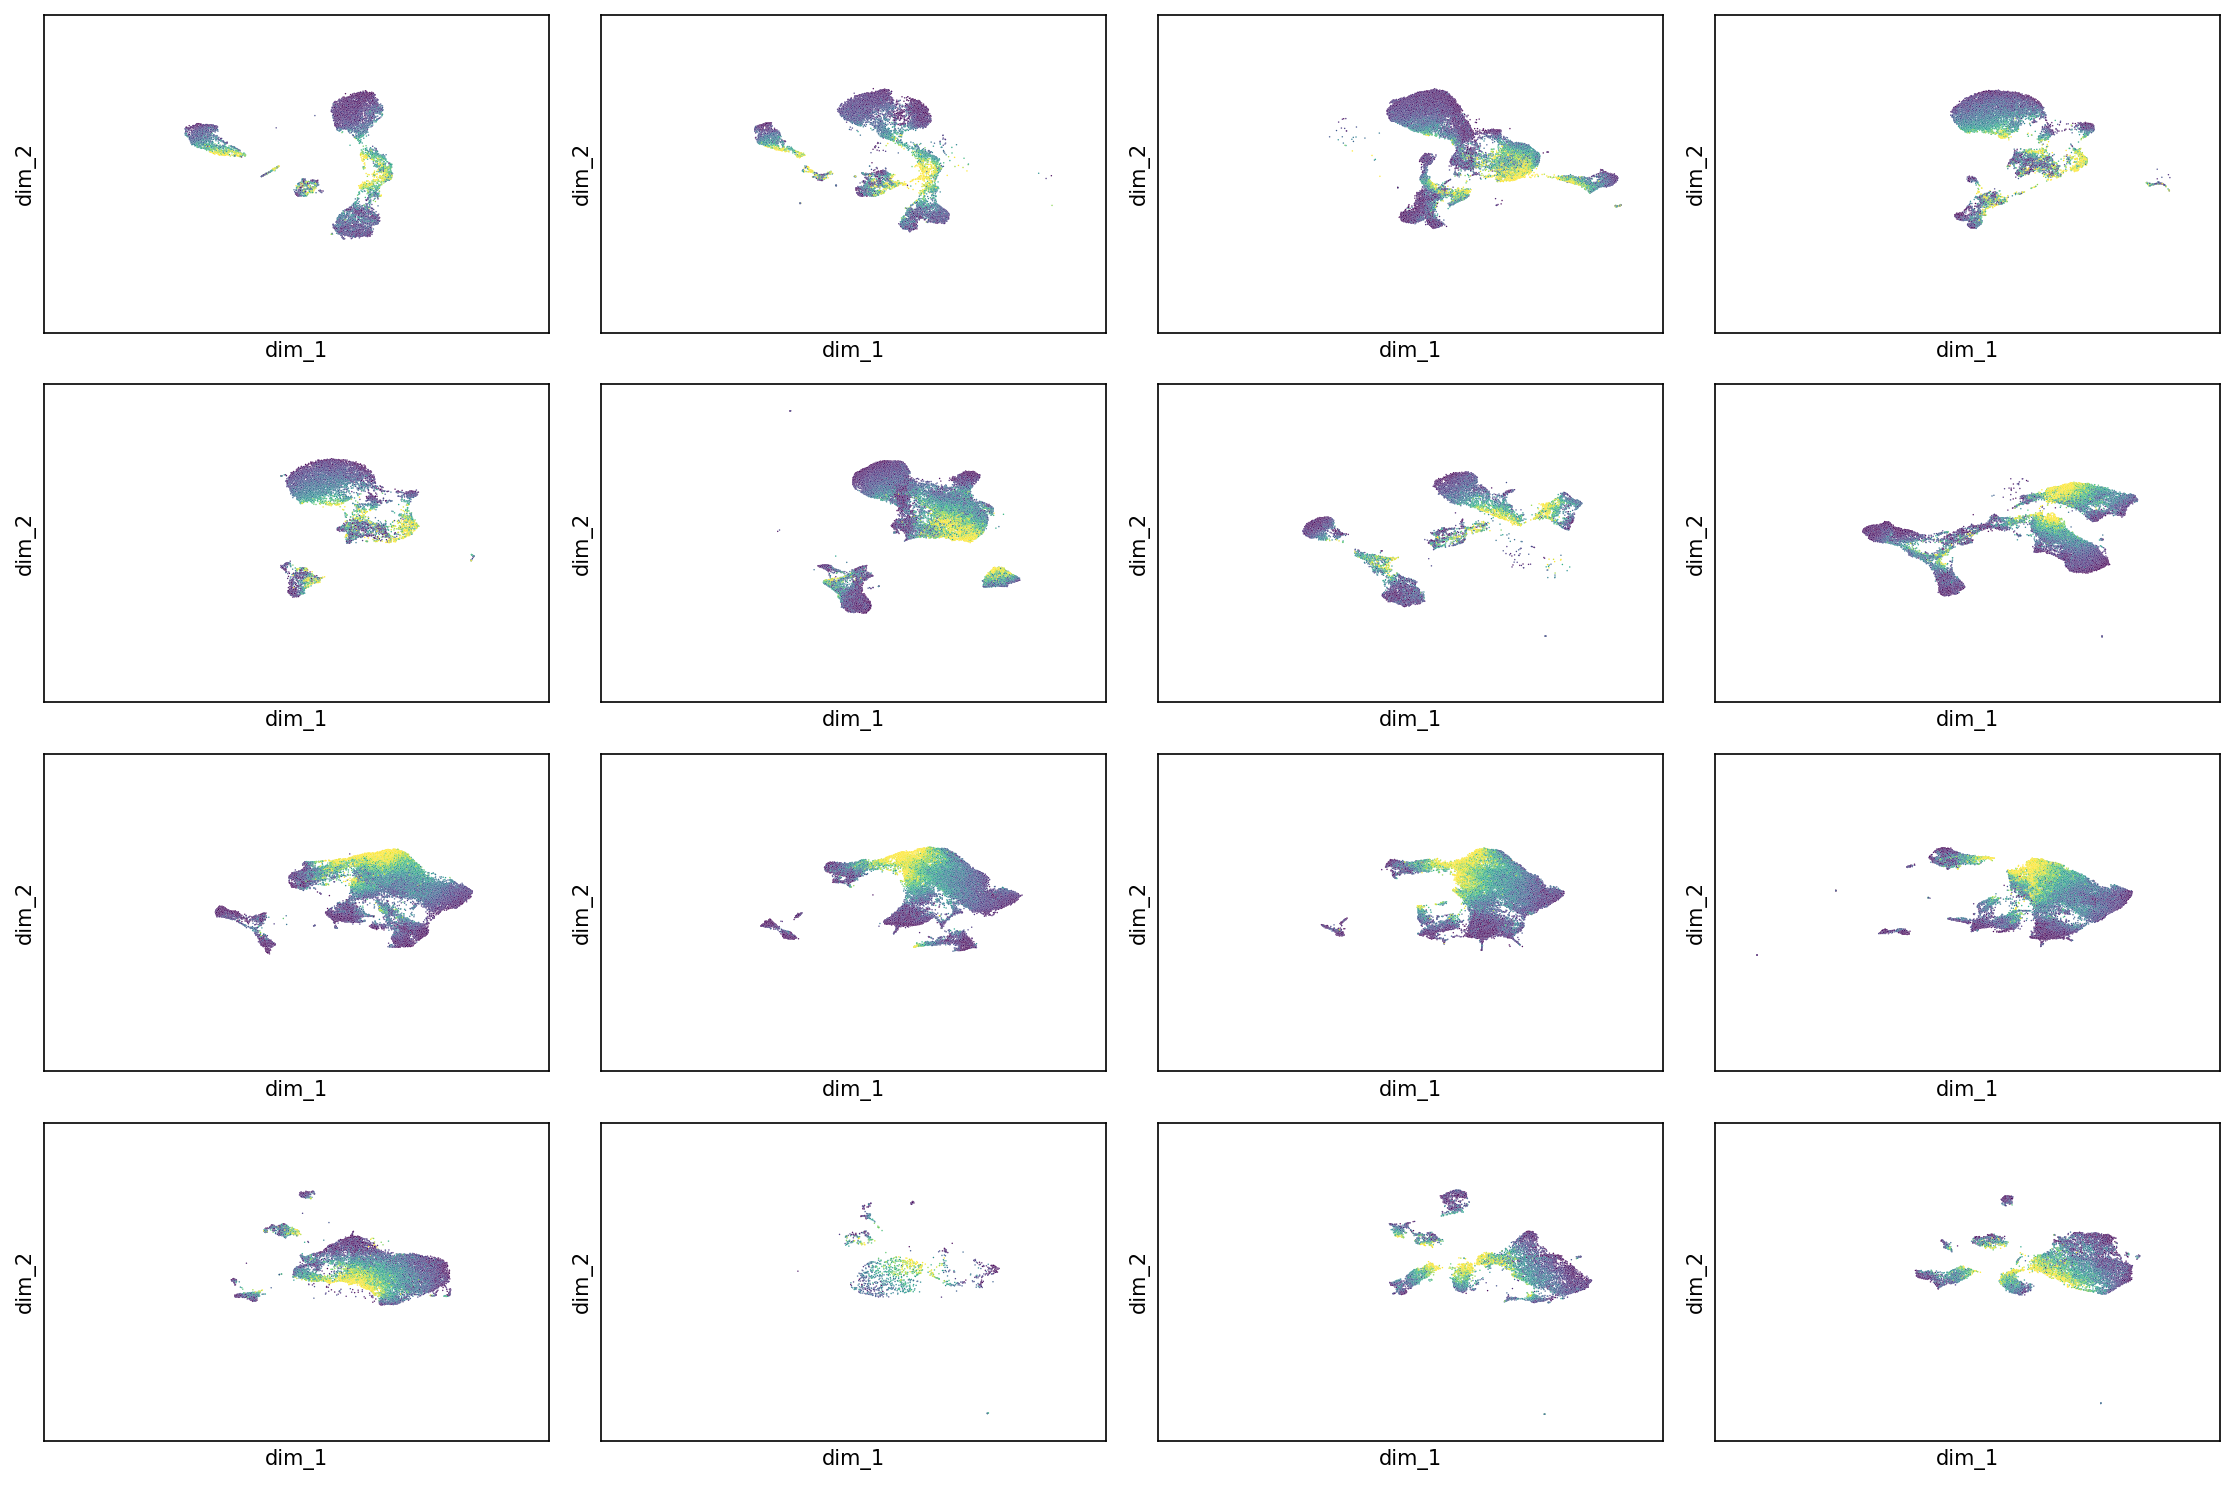

In [48]:
fig, axs = plt.subplots(4,4, figsize=(15, 10), dpi=150)
ax_bound = axis_bounds(numpy.vstack(aligned_mapper.embeddings_))

for i, (ax, (idx, gdf)) in enumerate(zip(axs.flatten(), df.groupby("meta_timepoint", sort=True))):
    gdf["dim_1"] = aligned_mapper.embeddings_[i][:, 0]
    gdf["dim_2"] = aligned_mapper.embeddings_[i][:, 1]
    feat = "feat_area_m07"
    norm = matplotlib.colors.Normalize(vmin=gdf[feat].quantile(0.05), vmax=gdf[feat].quantile(0.95))
    seaborn.scatterplot(data=gdf, x="dim_1", y="dim_2", c=gdf[feat], s=0.5, cmap="viridis", norm=norm, ax=ax)
    ax.axis(ax_bound)
    ax.set(xticks=[], yticks=[])
plt.tight_layout()